# Kmean clustering of wallet addresses
This repository shows how we can cluster addresses by using the time series feture of the transactions.
First we prepare the data  and then run Kmean clustering algorithm and exploit the results for k=4. 

In [2]:
import sys
import os
from pathlib import Path
absolute_path = os.fspath(Path.cwd().parent)
if absolute_path not in sys.path:
    sys.path.append(absolute_path)

import random
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


from src.main.plot.figures import *

Select the chain

In [3]:
tx_chain = 'eth_std' 
p = 1 # ratio of data (for test)

In [4]:
relative_path_to_data = '/data/features/' + tx_chain 
path_to_data = absolute_path + relative_path_to_data
files = os.listdir(path_to_data)

In [5]:
df_eth = pd.read_csv(os.path.join(path_to_data, files[0]), index_col=0, skiprows=lambda i: i>0 and random.random() > p)
print(df_eth.shape)
df_eth.head(2)

(19027, 164)


,countUniqueInteracted,ratioUniqueInteracted,countTx,outgoing,outgoingRatio,gas__approximate_entropy__m_2__r_0.1,gas__approximate_entropy__m_2__r_0.3,gas__approximate_entropy__m_2__r_0.5,gas__approximate_entropy__m_2__r_0.7,gas__approximate_entropy__m_2__r_0.9,...,value__variation_coefficient,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__percentage_of_reoccurring_values_to_all_values,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_6,value__ratio_value_number_to_time_series_length
address,,,,,,,,,,,,,,,,,,,,,
0x00000000000cd56832ce5dfbcbff02e7ec639bc9,328.0,0.307981,1065,1047,0.983099,1.147788,0.69575,0.442939,0.293566,0.243445,...,9.990080,0.8723,0.326733,1.410346,2.371219,3.365849,0.00939,0.003756,0.001878,0.189671
0x000000000f709dfe4346b80009b8a5197f79aa14,2.0,1.000000,2,1,0.500000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.800797,0.0000,0.000000,1.458715,2.233092,2.813355,0.00000,0.000000,0.000000,1.000000


In [6]:
df = df_eth
df.shape

(19027, 164)

First we remove duplicates features:

In [7]:
#drop duplicate columns
df_dup = df.T.drop_duplicates().T
df_dup.shape

(19027, 157)

Remove features with a very smal standard deviation

In [8]:
# drop 0 std
col_var = df_dup.columns[df_dup.std() <10E-20]
df_dup = df_dup.drop(columns=col_var)
print(df_dup.shape)

(19027, 156)


We remarked that outgoing is highly correlated with countTx, so we create a new column with incomming transactions
The ratio outgoing/countTx is not correlated 

In [9]:
df_dup['incomming'] = df_dup['countTx'] - df_dup['outgoing'] 
df['incomming'] = df['countTx'] - df['outgoing'] 

Peform Standardization of the data

In [10]:
X_train = df_dup.values
scaler = StandardScaler().fit(X_train)
print(scaler)

np_std = scaler.transform(X_train)
df_std = pd.DataFrame(np_std, index=df_dup.index, columns=df_dup.columns)
df_std.shape

StandardScaler()


(19027, 157)

Remove correlated feature by only keeping one feature if the absolute correlation between two columns is above 0.98

In [11]:
corr_pearson = df_std.corr(method='pearson')
corr_value_max = 0.98
corr_column_high = []
corr_column_high_dict = {}
corr_columns = corr_pearson.columns
l_columns = (len(corr_columns))
for i_col in range (l_columns):
    for i_row in range (i_col + 1, l_columns):
        if ((abs(corr_pearson.iloc[i_row, i_col])) > corr_value_max):  # type: ignore
            corr_column_high.append(corr_columns[i_row])
            corr_column_high_dict[corr_columns[i_row]] = corr_columns[i_col]

print(corr_column_high_dict)
print(corr_column_high)
print("Removed columns : ")
df_uncorr = df_std.drop(columns=corr_column_high)

print(df_uncorr.shape)
np_uncorr = df_uncorr.values

{'outgoing': 'countTx', 'gas__count_below_mean': 'outgoing', 'gasPrice__count_above_mean': 'outgoing', 'gasPrice__count_below_mean': 'gas__count_below_mean', 'value__count_below_mean': 'gasPrice__count_below_mean', 'timeStamp__variance_larger_than_standard_deviation': 'gasPrice__variance_larger_than_standard_deviation', 'gasPrice__ratio_value_number_to_time_series_length': 'gasPrice__percentage_of_reoccurring_datapoints_to_all_datapoints', 'timeStamp__variation_coefficient': 'timeStamp__standard_deviation', 'value__mean_abs_change': 'value__mean', 'value__ratio_value_number_to_time_series_length': 'value__percentage_of_reoccurring_datapoints_to_all_datapoints'}
['outgoing', 'gas__count_below_mean', 'gasPrice__count_above_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'gas__count_below_mean', 'gasPrice__count_above_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'gasPrice__count_below_mean', 'value__count_below_mean', 'value__count_below_mean', 'timeStam

We run Kmean a first time, this will allow us to remove outliers

In [ ]:
kmeans_results = []
min_cluster = 2
max_cluster = 16
for k in range (min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(np_uncorr)
    kmeans_results.append(kmeans)

kmeans_inertia = [k.inertia_ for k in kmeans_results]

Plot the K-means inertia in function of the number of cluster in ordxer to apply the elbow method.

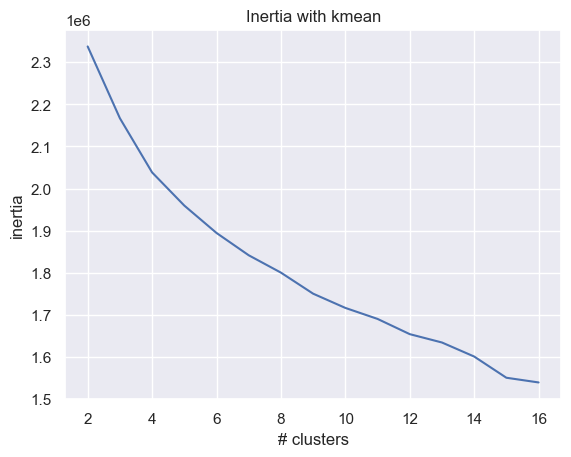

In [13]:
range_n_clusters = np.linspace(min_cluster, max_cluster, max_cluster-min_cluster+1)
ax = sns.lineplot(x=range_n_clusters, y=kmeans_inertia)
ax.set_title('Inertia with kmean')
ax.set_ylabel('inertia')
ax.set_xlabel('# clusters')

kmeans_silhouette = [silhouette_score(np_uncorr, k.labels_)  for k in kmeans_results]


There is no clear elbow and the inertia keeps decreasing as we increase the number of clusters.

At k=16 some clusters are very small, they represent one or two address. We decide to remove the clusters representing less than 1% of the data when k=15

In [14]:
n_clusters = 15
df_occurences, cluster_labels = get_df_occurences(np_uncorr, kmeans_results, n_clusters, min_cluster)
print(df_occurences)

    occurences  percentage
14        3948   20.749461
3         3806   20.003153
1         2568   13.496610
2         2536   13.328428
13        1878    9.870184
11        1378    7.242340
7          803    4.220318
5          700    3.678982
4          607    3.190203
9          525    2.759237
0          172    0.903979
8          102    0.536080
12           2    0.010511
6            1    0.005256
10           1    0.005256


Create an embedded 2D space with t-SNE in order to be able to plot the cluster on a scatter plot.

d:\Perso\Gitcoin\Hackathon_open_data\vGitcoinViz\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


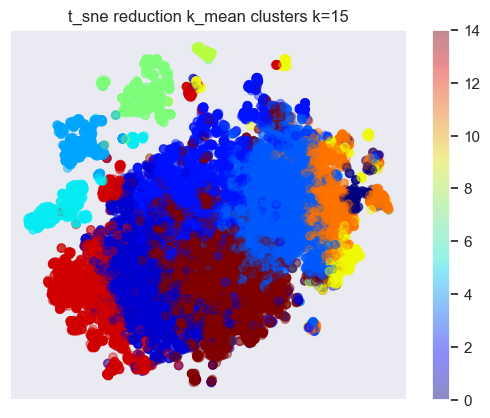

In [15]:
X_embedded_uncorr = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(np_uncorr)
# %%
scatter_plot_2d(X_embedded_uncorr, cluster_labels, 't_sne reduction k_mean clusters k={}'.format(n_clusters))


We remark thatthe t-SNE allows to give a flat representation of the feature space while showing boundaries between clusters.

In [16]:
#remove outliers
df_small_cluster = df_occurences[df_occurences['percentage'] < 1]
cluster_to_drop = df_small_cluster.index.values
print(cluster_to_drop)
index_to_keep = [cl not in cluster_to_drop for cl in cluster_labels]

[ 0  8 12  6 10]


In [17]:
df_no_outliers = df_uncorr.iloc[index_to_keep,:]
print(df_no_outliers.shape)
df_no_outliers_not_normalized = df.loc[index_to_keep, df_no_outliers.columns]  # type: ignore

(18749, 147)


We ran K-means again without the outliers for k between 2 and 8 as we are looking for 4 groups of users: Native, Noob, Farmers, Sybil

For each k we plot the silhouette score of kmean as well as the cluster in the embedded space.
We also print 4 random addresses from the cluster in order to make it easier to check on Etherscan the kind of users of the cluster.

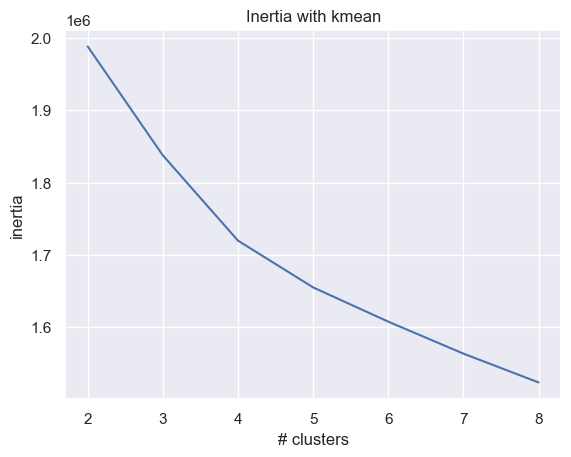

In [18]:
#run k_mean again without outliers
np_no_outliers = df_no_outliers.to_numpy()
kmeans_results = []
min_cluster = 2
max_cluster = 8
for k in range (min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(np_no_outliers)
    kmeans_results.append(kmeans)

kmeans_inertia = [k.inertia_ for k in kmeans_results]

range_n_clusters = np.linspace(min_cluster,max_cluster,max_cluster-min_cluster+1)
ax = sns.lineplot(x=range_n_clusters, y=kmeans_inertia)
ax.set_title('Inertia with kmean')
ax.set_ylabel('inertia')
ax.set_xlabel('# clusters')

kmeans_silhouette = [silhouette_score(np_no_outliers, k.labels_)  for k in kmeans_results]

In [19]:
X_embedded_no_outliers = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(np_no_outliers)

d:\Perso\Gitcoin\Hackathon_open_data\vGitcoinViz\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.2467498746602833
   occurences  percentage
1       12889      68.745
0        5860      31.255


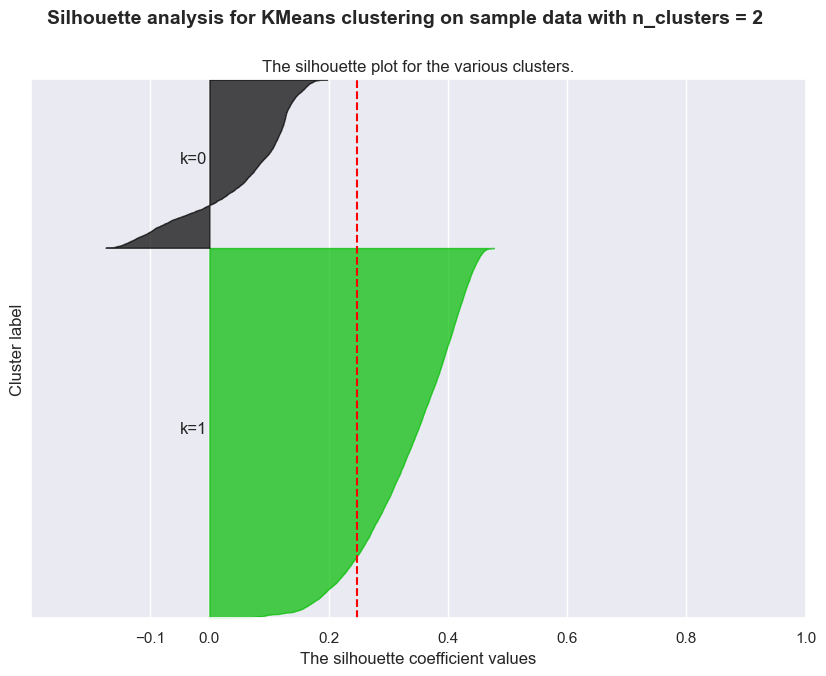

   occurences  percentage
1       12889      68.745
0        5860      31.255


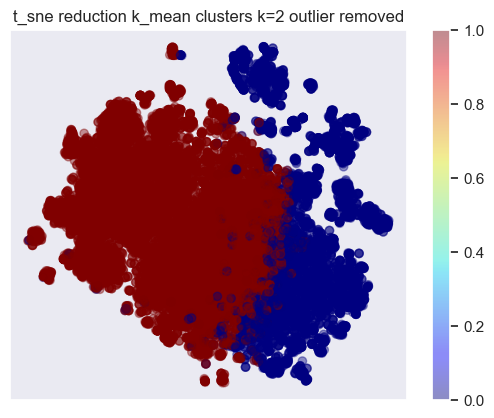

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=2, cluster = 1
Index(['0x05211b706bce6a569d556faa5821237464f33001',
       '0x77d4d7ed546b19077720eda2be8c847a1c358125',
       '0x92a92b89124c620fab72d3ed741b859040e42f12',
       '0xf774cf9388178479203c07404537ded2655ab9a6'],
      dtype='object', name='address')
k=2, cluster = 0
Index(['0x25040fc87271e37a45bdb35680fd9a1f68e953f4',
       '0x85b2d2707ddd2bf0ff717c9edb9271c2a3c6ca1c',
       '0x62ebe144f19c1473c9f93a3752f841476bb9fcb9',
       '0xe70812c22357a705b82e5c3d8a6467ed9b002f7b'],
      dtype='object', name='address')
For n_clusters = 3 The average silhouette_score is : 0.11206747673089039
   occurences  percentage
0        8577   45.746440
2        5479   29.222892
1        4693   25.030668


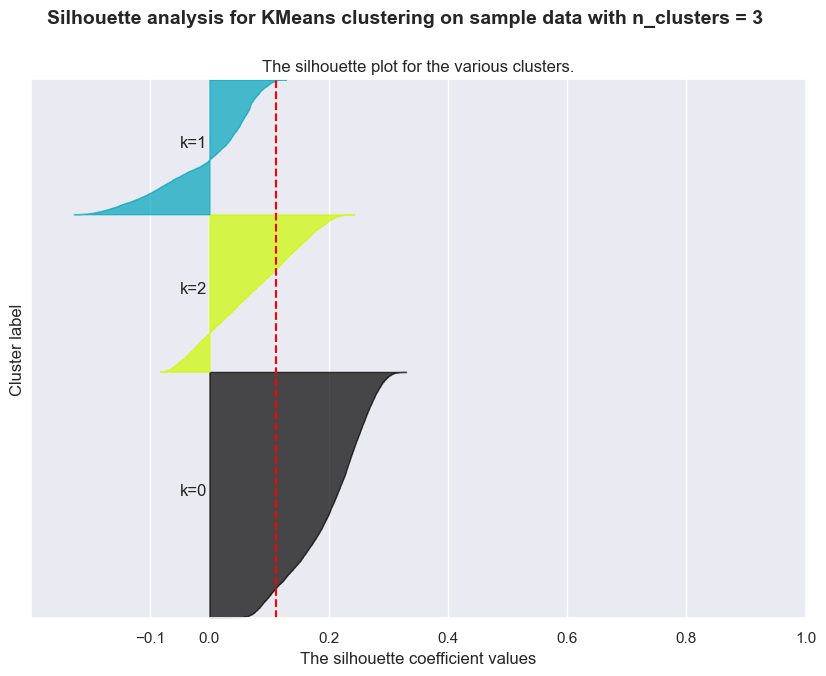

   occurences  percentage
0        8577   45.746440
2        5479   29.222892
1        4693   25.030668


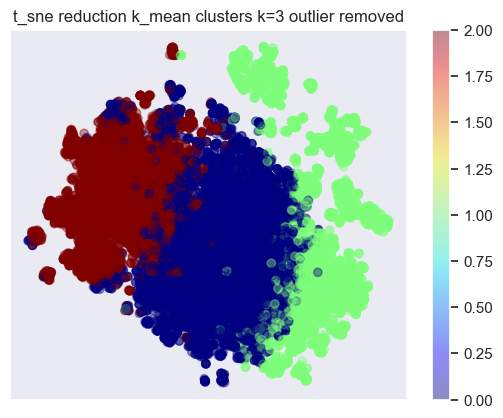

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=3, cluster = 0
Index(['0x3dea2325af266b618d1c6442ca0cbd3dfec37ed6',
       '0xd6c258b34eee58526177686aa2f1934ff5fbab51',
       '0x8e90e0abc6fa3176c010662327f8a47cd1fe3e29',
       '0xcffb2356a9d4fb84413e0a544c62db26c1dcbe74'],
      dtype='object', name='address')
k=3, cluster = 2
Index(['0xe867e34deeee413bd46a53fe69ac0c5368d7154a',
       '0x351be771eab8c8c5115928ecfb2ab758f512b555',
       '0xd111886cb7eff60f390e8f4c4f7c288c21988d51',
       '0x902fc38af709401a7cf604b333bbcde86499528f'],
      dtype='object', name='address')
k=3, cluster = 1
Index(['0xeb9696a04b982584418390f53451e0ceb1a0b0b3',
       '0x12dfdaebc4c6c467c27638d3ea21fafc4ab2bbbb',
       '0x143f202eedc40b7d09d47c65a2bd1943f16e4e31',
       '0x9f1d5886252102924d710e42285a8f5519599c5c'],
      dtype='object', name='address')
For n_clusters = 4 The average silhouette_score is : 0.1299959048861804
   occurences  percentage
2        8500   45.335751
0        5193   27.697477
3        3644   19.435703
1        1412    7.5

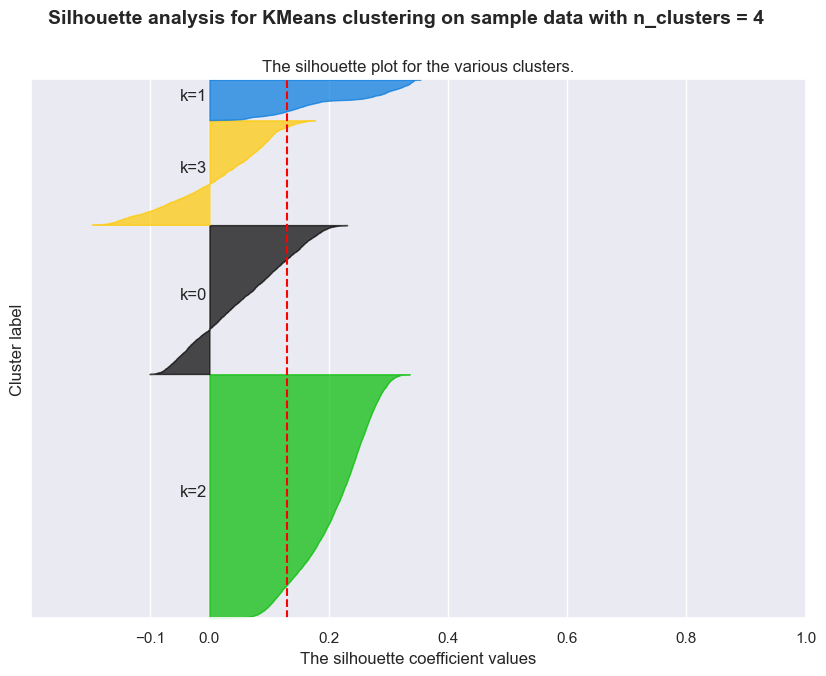

   occurences  percentage
2        8500   45.335751
0        5193   27.697477
3        3644   19.435703
1        1412    7.531068


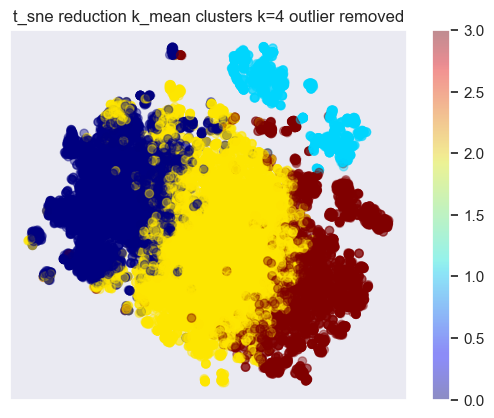

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=4, cluster = 2
Index(['0x0d6a9963f7b362c3d50cfdfdc9207b4d8e766c13',
       '0x5f8b1d3143a042d6c2116cd0ea1db0503c176885',
       '0x0f3f7c8d5c7f93b223ba2cb0cfd9514fba15ed96',
       '0x0cc0fdfa2a9edfc89087e405a4d4b6120ea686fb'],
      dtype='object', name='address')
k=4, cluster = 0
Index(['0xad2b2f8044986cb8f0148a03fe14c5551272386f',
       '0xb9c29b3ef0cf74b6591fce755e79616c3e77f024',
       '0xbdbc9751d73f29cfddb285eba08ffdb7b3395dfe',
       '0x8afeb17641ce3bfe786a6c4e1bf000cd8a268c96'],
      dtype='object', name='address')
k=4, cluster = 3
Index(['0xad6fd97ab003c66a1121c6a8801ff917cd799f61',
       '0xcdfeb3b0a870764d0ef4e882038fc8367380ccc6',
       '0xc8edec5d005ebb18f7ba3f816fd1d1c606c10dd6',
       '0x20e3f2155fe9bfb22413882b52783c289be4937e'],
      dtype='object', name='address')
k=4, cluster = 1
Index(['0x90773f946de726a7be61d00f6c5542241a9441cb',
       '0xa70d36cd8ab6454ff736bd66b3089b3a693ea045',
       '0x67ba333d253d12b2cda615382d4e09a4f79f932b',
       '0xd01db03984

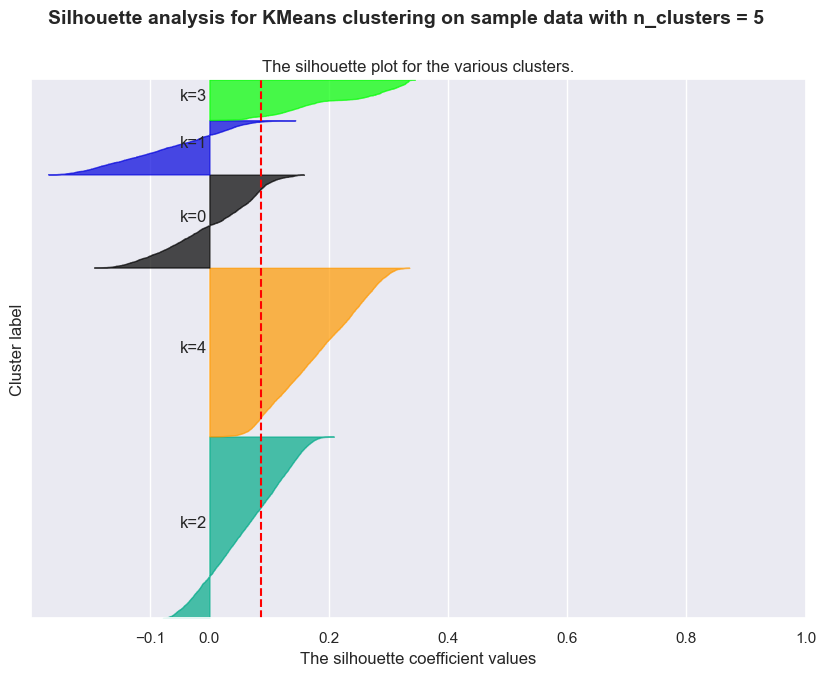

   occurences  percentage
2        6330   33.761801
4        5879   31.356339
0        3241   17.286255
1        1887   10.064537
3        1412    7.531068


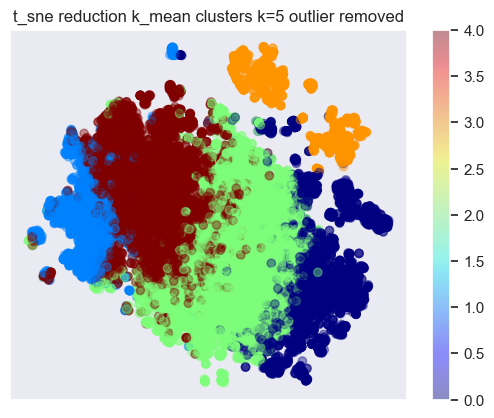

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=5, cluster = 2
Index(['0x6e24b7c63d3c6b97cbf09d5f5595993bbc4da1fe',
       '0x17e2a33a7866e3c800cfcdc9efe2365022915f60',
       '0xd7828713347cbcb7a6bb36cd05c79e27bb0ceb1c',
       '0xbf00092368210cd867f67b658ca3855dc01cfe42'],
      dtype='object', name='address')
k=5, cluster = 4
Index(['0xed925f90d0639cdef4a1cfaf30f6ea4ab2bfd5cf',
       '0xca66b197d337f15f4b949e3201ee833c73665217',
       '0x483fbb92e9e0bef834c8ad42223267ecceaa6e8c',
       '0x64fca50c0da98c282d94d24061926976dec7c960'],
      dtype='object', name='address')
k=5, cluster = 0
Index(['0xb5bd4551b9073dcdf61f2c4d66a80fcdd0930bed',
       '0x56b04d40a8b15b5ec6784e167917b8f94b9ddbfd',
       '0xbf7a0213e50eacfb46c460f3913718ec1ee9a400',
       '0xb8f6c3175b868a100ed2f770355e726d7bab261a'],
      dtype='object', name='address')
k=5, cluster = 1
Index(['0x13adb88d0ce40651625b43b597019f9ce3d60bcc',
       '0x80981e56e4b23e5c29918a5cab64fa32251bd390',
       '0xc05bc25eaa52a23476e113b9a139a66e7473b364',
       '0x4892501b2c

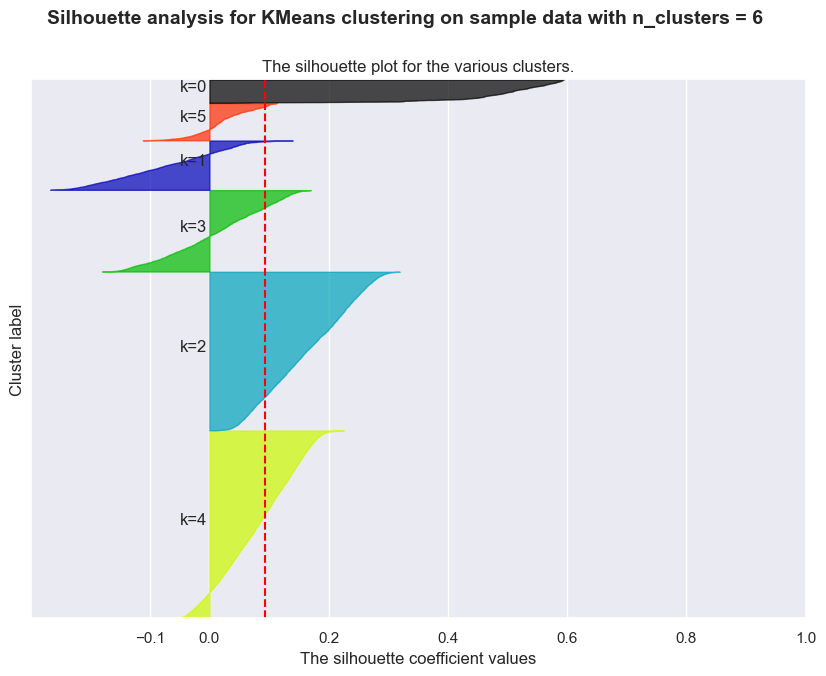

   occurences  percentage
4        6544   34.903195
2        5533   29.510907
3        2842   15.158142
1        1720    9.173823
5        1299    6.928370
0         811    4.325564


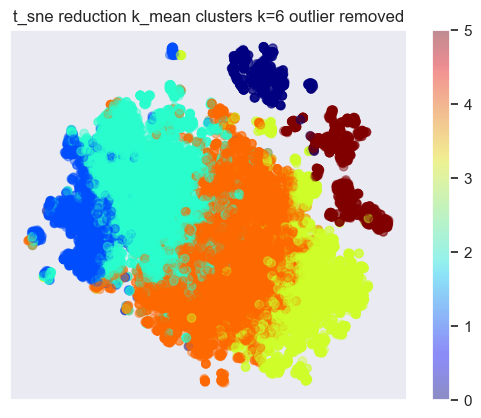

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=6, cluster = 4
Index(['0x40dbe607550d23cf8ece9abff14346d2a01beb63',
       '0x6e0c40adf39c21554ab2c7bf2fd7363e17b9e87a',
       '0x9a63106465bf0d9bf675fcd52fd7ceec3f079342',
       '0xcb926bcc7d6a2938e654058cab3ab058af07877e'],
      dtype='object', name='address')
k=6, cluster = 2
Index(['0x4ceaa0a16d0831d7d46cb72006f959a87f618a47',
       '0x624ceda8d049419692f362af668dc7585804a1c7',
       '0xbebd9051aa63ed001e3ce3b765fdb5db2472023d',
       '0x113204be8150654057fc08da084915fff513fab3'],
      dtype='object', name='address')
k=6, cluster = 3
Index(['0xafdb07bfc0f331be9e1a057f3ef92fa401de285d',
       '0x09636cdca9b3825d4f8b6b8ad714883701195885',
       '0x99071981aaa7ddf0bd139b6c93e941c288f16784',
       '0xfbe7de4d28c27c241dd71224996bf5cf37e5caf9'],
      dtype='object', name='address')
k=6, cluster = 1
Index(['0x34c0fd5f1dc4929549ad414026fc68060549f9c8',
       '0xbd411d7e10653911c14fc68d2b939067f2bf09fb',
       '0xa593ffdc9fda0a352eac5fb94b88d0fade6fc933',
       '0x99390c75db

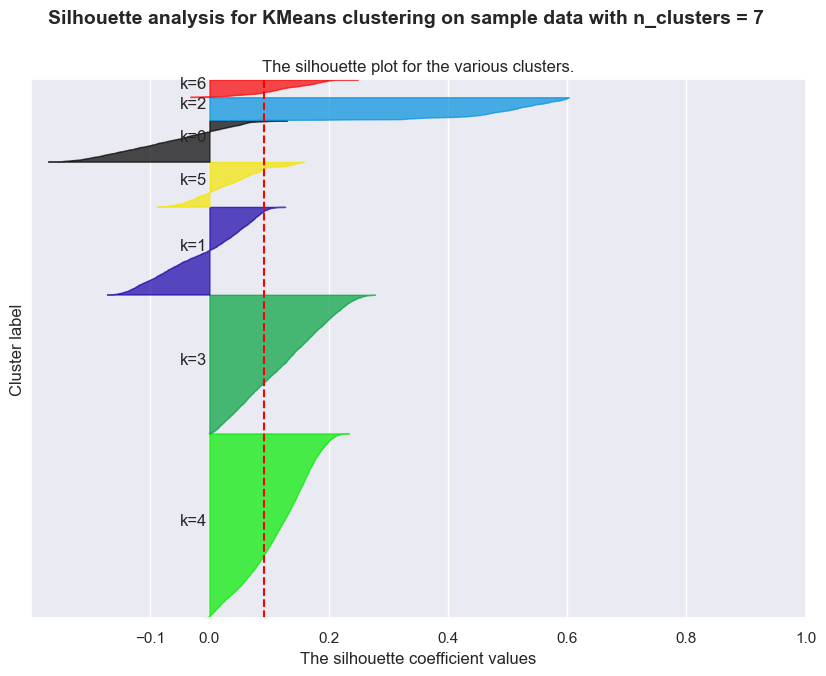

   occurences  percentage
4        6448   34.391168
3        4832   25.772041
1        3060   16.320870
5        1561    8.325777
0        1436    7.659075
2         805    4.293562
6         607    3.237506


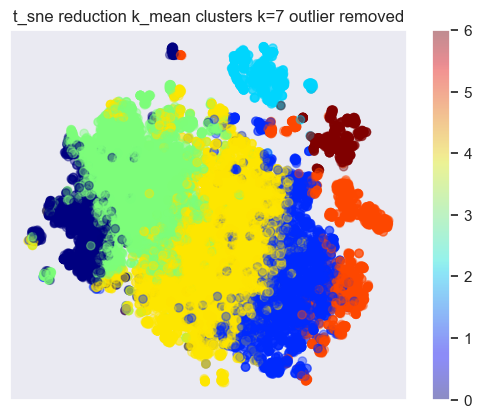

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


k=7, cluster = 4
Index(['0x1ab75fea1f27a6dfaff81b0371ab6d57e112906b',
       '0xb91d4b993ee9eb23797768910c79ff15f1ffc602',
       '0x4f21d5a802a734c8646752c32621b03ccabb5d37',
       '0x5a360f90a949aa4ebd402d6533ea91395c25515d'],
      dtype='object', name='address')
k=7, cluster = 3
Index(['0xd0ae8768f691800a126a6ac562bad6e881d8c1f2',
       '0xd11256d99f8833bee0b99203ddcfe4cd6c823d8d',
       '0xb088e1d427ff9347366263149b1ecbb5a0a841e8',
       '0xec83e4768e314cdd88f910e397affcde78a52f92'],
      dtype='object', name='address')
k=7, cluster = 1
Index(['0x534958c32a3e282086a5d1737a320ae038d9def6',
       '0x6ff722e4986f1d44fd7572594cacd3cdaaabe635',
       '0x7cd43a141f3fa58f4742d6347670d5e827ba9605',
       '0x8d8d0d3a356c88cb7f29cb7372bf3ea90c783353'],
      dtype='object', name='address')
k=7, cluster = 5
Index(['0x477e90702a227390d3cc9d9ff1acfdc181105a78',
       '0xefb855025890ce03f662fc8565984a9b6f7433b0',
       '0x9ef1ea1dd819b008819d22b102a30ad914bf7fb1',
       '0xc8167d52f1

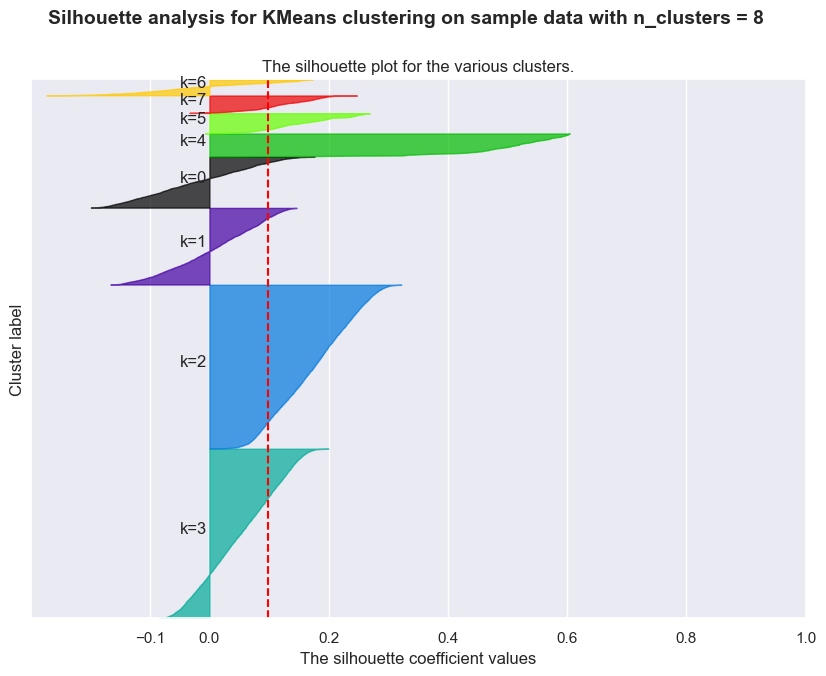

   occurences  percentage
3        5916   31.553683
2        5720   30.508294
1        2677   14.278095
0        1777    9.477839
4         803    4.282895
5         700    3.733532
7         607    3.237506
6         549    2.928156


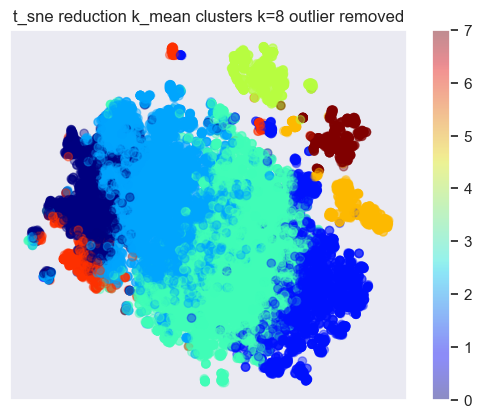

k=8, cluster = 3
Index(['0x3a575a7def403788401e73aaa42294443c68bc36',
       '0xc438b2cf974de5f8bfe2ef1e39ed676d7ffcc538',
       '0xce609f75d433762d31880479444077a15553efc5',
       '0x436f71b5be74ccdcaaf7390d0c679c6d31fafa7d'],
      dtype='object', name='address')
k=8, cluster = 2
Index(['0x31e2c97f45747d48630ca3560ee57f9aeccfbed9',
       '0xd838841ab5bd184c91c68b3bf9e3ac3ddf2ce04b',
       '0x4a307ebd3b8b63a5d39cd7a00a87a666506e31f9',
       '0x0bf1fee0f3dbb4031e4c12e2985df93f267d53ab'],
      dtype='object', name='address')
k=8, cluster = 1
Index(['0xfcb2be8c0a9f428bfb8b94becc8b50097d5fb733',
       '0xbf467bb45464528afa56999df9869cb40e41b4e9',
       '0xfbe7de4d28c27c241dd71224996bf5cf37e5caf9',
       '0xb3c85111afa40b0cb89eee736cacef074e8f23ca'],
      dtype='object', name='address')
k=8, cluster = 0
Index(['0x96f1542746782850c86d2ae5ae729c655df447fd',
       '0xb5a8168c066ef50d63c65501087b7185f8c36279',
       '0x26439aeb008d63b6686798b5f08a84c7abefbd80',
       '0x29be3db3e9

d:\Perso\Gitcoin\Hackathon_open_data\src\main\plot\figures.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = cluster_labels


In [20]:
plot_silhouette_tsne_save_hist(df_no_outliers, kmeans_results, kmeans_silhouette, min_cluster, max_cluster, X_embedded_no_outliers, absolute_path, tx_chain)

The last code space below allows to export the histogram of all the features with a superpostion by cluster. 

In [22]:
# This part is very memmory heavy due to some features with very high value.
np_dataset = df_no_outliers_not_normalized.values
n_cluster = 4 # choose the number of cluster for the export.

df_occurences, cluster_labels = get_df_occurences(np_dataset, kmeans_results, n_cluster, min_cluster)

path_charts = os.path.join(absolute_path, "charts_kmean")
path_charts = os.path.join(path_charts, tx_chain)
path_charts = os.path.join(path_charts, "k={}".format(n_cluster))

df_no_outliers_not_normalized["cluster"] = cluster_labels

cluster_col_name = "cluster"   
cols = df_no_outliers_not_normalized.columns
debug = True

for i in range (0, len(cols)):
    i_col = cols[i]
    if i_col not in ["timeStamp__variance_larger_than_standard_deviation", "value__abs_energy"]: # cause bug out of memory!
        if debug:
            print(str(i) + " " + str(i_col))
            
        if cluster_col_name == None:
            sns_plot = sns.histplot(df_no_outliers_not_normalized, x=i_col)
        else:
            n_cluster = len(df_no_outliers_not_normalized[cluster_col_name].unique())
            sns_plot = sns.histplot(df_no_outliers_not_normalized, x=i_col, hue=cluster_col_name, palette=sns.color_palette('bright', n_colors=n_cluster))
        fig_name = str(i_col) + ".png"
        fig = sns_plot.get_figure()

        if not os.path.exists(path_charts):
            os.makedirs(path_charts)

        fig.savefig(os.path.join(path_charts, fig_name))
        fig.clf() 
        plt.close()
# save_hist(df_no_outliers_not_normalized, path_charts, cluster_col_name="cluster", debug=False)

0 countUniqueInteracted
1 ratioUniqueInteracted
2 countTx
3 outgoingRatio
4 gas__approximate_entropy__m_2__r_0.1
5 gas__approximate_entropy__m_2__r_0.3
6 gas__approximate_entropy__m_2__r_0.5
7 gas__approximate_entropy__m_2__r_0.7
8 gas__approximate_entropy__m_2__r_0.9
9 gas__autocorrelation__lag_1
10 gas__autocorrelation__lag_2
11 gas__autocorrelation__lag_3
12 gas__autocorrelation__lag_4
13 gas__benford_correlation
14 gas__binned_entropy__max_bins_5
15 gas__count_above_mean
16 gas__has_duplicate
17 gas__maximum
18 gas__mean
19 gas__mean_abs_change
20 gas__mean_change
21 gas__mean_second_derivative_central
22 gas__median
23 gas__minimum
24 gas__skewness
25 gas__standard_deviation
26 gas__variance
27 gas__variance_larger_than_standard_deviation
28 gas__variation_coefficient
29 gas__percentage_of_reoccurring_datapoints_to_all_datapoints
30 gas__percentage_of_reoccurring_values_to_all_values
31 gas__permutation_entropy__dimension_3__tau_1
32 gas__permutation_entropy__dimension_4__tau_1
33

In [2]:
df_no_outliers_not_normalized

NameError: name 'df_no_outliers_not_normalized' is not defined